## 1. Data preprocessing ##

### 1.1 Prepare relevent libraries ###

In [32]:
import numpy as np
from pandas import DataFrame
import pandas as pd
from datetime import datetime
from matplotlib import pyplot
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from matplotlib import style
from scipy import stats

import datetime as dt
import matplotlib.pyplot as plt
import pandas_datareader.data as web
style.use('ggplot')

### 1.2 Take a sample stock(apple) price dataset ###

In [33]:
start = dt.datetime(2017,6,1)
end = dt.datetime(2019,12,31)

In [34]:
def get_thedata2(name, start, end):
    stock = web.DataReader(name, 'yahoo', start, end)
    stock = stock.reset_index().rename(columns = {"index":"Date"})
    stock = stock[['Date','Open','High','Low']]
    stock.columns=['Date','Open','High','Low']
    stock = stock.reset_index(drop = True)
    return stock

In [35]:
apple1 = get_thedata2('AAPL', start, end)

In [36]:
apple1.tail()

,Date,Open,High,Low
646,2019-12-24,71.172501,71.222504,70.730003
647,2019-12-26,71.205002,72.495003,71.175003
648,2019-12-27,72.779999,73.492500,72.029999
649,2019-12-30,72.364998,73.172501,71.305000
650,2019-12-31,72.482498,73.419998,72.379997


### 1.3 Create useful columns with original columns ###

First, I want to check the gap between Opening price and Highest price(Opening & Lowest price)
So, made a function that can create new two columns. 
To test the function, I just used apple stock data. Later we'll apply diverse company dataset.

In [37]:
def get_moving(stock):
    
    check_low = []
    check_high = []
    
    for i in range(len(stock)):
        low_ratio = round(stock.loc[i]['Low']/stock.loc[i]['Open']*100 - 100,3)
        check_low.append(low_ratio)
    stock['check_low'] = check_low
    
    for i in range(len(stock)):
        high_ratio = round(stock.loc[i]['High']/stock.loc[i]['Open']*100 - 100,3)
        check_high.append(high_ratio)
    stock['check_high'] = check_high
            
    return stock

In [38]:
apple1 = get_moving(apple1)

In [39]:
apple1.tail()

,Date,Open,High,Low,check_low,check_high
646,2019-12-24,71.172501,71.222504,70.730003,-0.622,0.070
647,2019-12-26,71.205002,72.495003,71.175003,-0.042,1.812
648,2019-12-27,72.779999,73.492500,72.029999,-1.031,0.979
649,2019-12-30,72.364998,73.172501,71.305000,-1.465,1.116
650,2019-12-31,72.482498,73.419998,72.379997,-0.141,1.293


Second, I want to generate a moving average column. 
But every company stock will have a different size, so before generating the moving average column, I normalized the Opening price first.

In [40]:
def min_max_normalize(lst):
    normalized = []
    for value in lst:
        normalized_num = (value - min(lst)) / (max(lst) - min(lst))
        normalized.append(normalized_num)
    
    return normalized

In [41]:
def get_normalized(stock):
    opening = stock['Open']
    normalized_open = min_max_normalize(opening)
    normalized_moving = []
    
    for i in range(len(normalized_open)):
        if i < 5:
            temp = 0
        else:
            #opening = round(stock.loc[i]['Open'],3)
            d_1 = round(normalized_open[i-1],3)
            d_2 = round(normalized_open[i-2],3)
            d_3 = round(normalized_open[i-3],3)
            d_4 = round(normalized_open[i-4],3)
            d_5 = round(normalized_open[i-5],3)
            
            temp = round((d_1 + d_2 + d_3 + d_4 + d_5)/5,3)
        normalized_moving.append(temp)
    
    stock['normalized_open'] = normalized_open
    stock['normalized_moving'] = normalized_moving
    
    stock = stock[5:]
    stock = stock.reset_index(drop=True)
    stock['Date'] = pd.to_datetime(stock['Date'])
    stock.set_index(stock['Date'], inplace=True)
    stock = stock.drop('Date', 1)
    
    return stock

In [42]:
apple1 = get_normalized(apple1)

In [43]:
apple1.tail()

,Open,High,Low,check_low,check_high,normalized_open,normalized_moving
Date,,,,,,,
2019-12-24,71.172501,71.222504,70.730003,-0.622,0.070,0.956619,0.927
2019-12-26,71.205002,72.495003,71.175003,-0.042,1.812,0.957496,0.934
2019-12-27,72.779999,73.492500,72.029999,-1.031,0.979,1.000000,0.941
2019-12-30,72.364998,73.172501,71.305000,-1.465,1.116,0.988800,0.957
2019-12-31,72.482498,73.419998,72.379997,-0.141,1.293,0.991971,0.966


## 2. EDA ##

### 2.1. Compare opening price and moving average ###

I want to decide when I can get into the stock market by comparing the Opening price and moving average. So, I made a function which can compare a difference between two variables and return the gap by 5 class.

In [44]:
def compare_open_moving(stock):   
    normalized_open = stock['normalized_open']
    normalized_moving = stock['normalized_moving']
    
    expensive = 0
    cheap = 0
    cheap_1 = 0
    cheap_2 = 0
    cheap_3 = 0
    
    left_case = 0
    checking = []
    
    for i in range(len(stock)):
        open_moving_diff = round((normalized_open[i] - normalized_moving[i]),3)
        checking.append(open_moving_diff)
    for i in checking:
        if i >= 0:
            expensive += 1
        elif i > -0.01:
            cheap += 1
        elif i > -0.02:
            cheap_1 += 1
        elif i > -0.03:
            cheap_2 += 1
        elif i > -0.2:    
            cheap_3 += 1  
        else:
            print(i)
            left_case += 1
    stats = [expensive, cheap, cheap_1, cheap_2, cheap_3]
    return stats

In [45]:
compare_open_moving_apple = compare_open_moving(apple1)

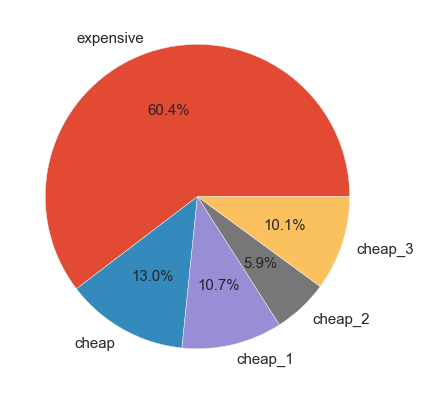

In [46]:
labels = ['expensive', 'cheap', 'cheap_1', 'cheap_2', 'cheap_3']
sizes = compare_open_moving_apple
plt.figure(figsize=(7,7))
plt.rc('font',size = 15)
plt.rc('xtick',labelsize = 15)
plt.pie(sizes, labels = labels, autopct='%2.1f%%')
plt.show()

### 2.2. Compare the gap between highest price & opening price (lowest & opening) ###

Second, I want to decide when I can sell what I bought by comparing the Opening price and highest price(opening price & lowest price). So, I made a function which can compare a difference between two variables.

In [47]:
apple1_up_down = apple1[['check_low','check_high']]

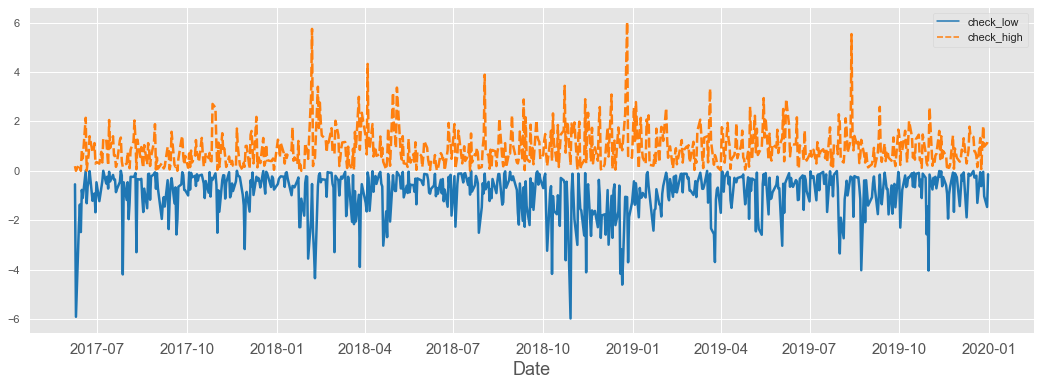

In [48]:
plt.figure(figsize=(18,6))
b = sns.lineplot(data=apple1_up_down, sort=True, linewidth=2.5,
            palette="tab10")

In [49]:
under_2 = 0
over_2 = 0
for i in apple1_up_down['check_high']:
    if i>= 2:
        over_2 += 1
    else:
        under_2 += 1
print(under_2)
print(over_2)

595
51


In [50]:
under_minus2 = 0
over_minus2 = 0
for i in apple1_up_down['check_low']:
    if i>= -2:
        under_minus2 += 1
    else:
        over_minus2 += 1
print(under_minus2)
print(over_minus2)

582
64


## 3. Hypothesis test ##

Based on Chapter 2 above, sometimes I intervene in the stock market and sometimes I do not. I hope that when I intervene in the stock market, the stock price fluctuates greatly during the day. Therefore, the hypothesis test confirmed that there was a significant difference in the range of stock prices between the two groups.

In [51]:
def prepare_t_test(ttest):
    ttest_high_cheap = []
    ttest_high_normal = []
    ttest_low_cheap = []
    ttest_low_normal = []
    for i in range(len(ttest)):
        normal_open = ttest.iloc[i]['normalized_open']
        normal_moving = ttest.iloc[i]['normalized_moving']
        ch_low = ttest.iloc[i]['check_low']
        ch_high = ttest.iloc[i]['check_high']

        if (normal_open - normal_moving) < -0.03:
            ttest_high_cheap.append(ch_high)
            ttest_low_cheap.append(ch_low)
        else:
            ttest_high_normal.append(ch_high)
            ttest_low_normal.append(ch_low)
            
    return ttest_high_cheap, ttest_high_normal, ttest_low_cheap, ttest_low_normal

The hypothesis test is conducted twice independently of the difference between the opening price and the highest price, and the difference between the opening price and the lowest price.

In [52]:
our_data = ['NFLX', 'AAPL', 'AMZN', 'GOOG','ZM']
our_name = ['netflix', 'apple', 'amazon', 'google','zoom']

In [53]:
start = dt.datetime(2017,1,1)
end = dt.datetime(2019,12,31)

Previously, only Apple shares were used at the EDA stage, but from now on, they are tested using data from five prominent U.S. companies to repeatedly implement the same procedures as hypothesis tests.

In [54]:

for i in range(len(our_data)):
    
    print("This is ",our_name[i]," stocks")
    stock = get_thedata2(our_data[i], start, end)
    
    stock = get_moving(stock)
    stock = get_normalized(stock)
    
    ttest = stock[['check_high','check_low', 'normalized_open', 'normalized_moving']]
    ttest_high_cheap, ttest_high_normal, ttest_low_cheap, ttest_low_normal = prepare_t_test(ttest)
    
    lresult = stats.levene(ttest_high_cheap, ttest_high_normal)
    if lresult[1] < 0.05:
        check_var = False
    else:
        check_var = True
    print("------------- Compare variance ----------------")
    print('LeveneResult(F) : %.3f \np-value : %.3f' % (lresult))
    print("------The gap between highest and opening------")
    result = stats.ttest_ind(ttest_high_cheap, ttest_high_normal, equal_var=check_var) 
    print('t statistic : %.3f \np-value : %.3f' % (result))
    print("-----------Compare mean of two group-----------")
    print("The average of highest point for cheap point is",round(np.mean(ttest_high_cheap),3))
    print("The average of highest point for normal point is",round(np.mean(ttest_high_normal),3))
    print("------------- Compare variance ----------------")
    lresult = stats.levene(ttest_low_cheap, ttest_low_normal)
    print('LeveneResult(F) : %.3f \np-value : %.3f' % (lresult))
    if lresult[1] < 0.05:
        check_var = False
    else:
        check_var = True
    print("------The gap between lowest and opening-------")
    result = stats.ttest_ind(ttest_low_cheap, ttest_low_normal, equal_var=check_var) 
    print('t statistic : %.3f \np-value : %.3f' % (result))
    print("-----------Compare mean of two group-----------")
    print("The average of lowest point for cheap point is",round(np.mean(ttest_low_cheap),3))
    print("The average of lowest point for normal point is",round(np.mean(ttest_low_normal),3))
    print("======================================================")
    print("======================================================")

This is  netflix  stocks
------------- Compare variance ----------------
LeveneResult(F) : 28.773 
p-value : 0.000
------The gap between highest and opening------
t statistic : 3.921 
p-value : 0.000
-----------Compare mean of two group-----------
The average of highest point for cheap point is 2.083
The average of highest point for normal point is 1.277
------------- Compare variance ----------------
LeveneResult(F) : 9.214 
p-value : 0.002
------The gap between lowest and opening-------
t statistic : -4.102 
p-value : 0.000
-----------Compare mean of two group-----------
The average of lowest point for cheap point is -2.19
The average of lowest point for normal point is -1.413
This is  apple  stocks
------------- Compare variance ----------------
LeveneResult(F) : 22.926 
p-value : 0.000
------The gap between highest and opening------
t statistic : 3.290 
p-value : 0.002
-----------Compare mean of two group-----------
The average of highest point for cheap point is 1.377
The average 

Since all shares except Zoom shares can reject the null hypothesis, we will set up a trading algorithm for the rest of the companies except Zoom.

## 4. Creating a trading algorithm ##

All algorithms will be tested independently on various stock price data with $ 30,000.

All algorithms track the final assets, the circumstances of changes in total assets, changes in the number of shares held, cash holdings, and the price of shares.

In [55]:
commision = 0.00015    
tax = 0.0025

print('when you buy or sell, you have to pay commision',commision*100,"%")
print('when you sell your stock, you have to pay tax',tax*100,'%')

when you buy or sell, you have to pay commision 0.015 %
when you sell your stock, you have to pay tax 0.25 %


Taxes and commision will vary depending on the country and companies, but I am a Korean, so I based on Korean taxes and the usual commision of Korean firms. Taxes and commision are charged when we sell stocks, and only commision is charged when we buy stocks.

### 4.1. Buy_Sell v1 ###

The first trading algorithm has two rules. If the normalized opening price shows a difference of more than 0.02 than the normalized moving average, the shares are purchased in one share. Also, if the price of the stock increases by more than 3% compared to the opening price in the market, I will sell 2 shares, and if the price increases by more than 2%, I will sell 1 share.

In [56]:
def when_we_buy_sell_stock(stock):
    my_asset = 30000   # dollar
    my_stock = 0       # the number of apple stock
    holding_stocks = []  # track the number of stocks
    track = []           # track amount of assets (money + stock)
    track_money = []
    track_price = []     # track stock price(opening)
    
    normalized_open = stock['normalized_open']
    normalized_moving = stock['normalized_moving']
    
    for i in range(len(stock)):
        temp = stock.iloc[i]['Open']
        ch_high = stock.iloc[i]['check_high']
        
        open_moving_diff = round((normalized_open[i] - normalized_moving[i]),3)
        if open_moving_diff <= -0.02:
            changes = 1
            if my_asset > changes*temp*(1+commision):
                my_stock = my_stock + changes
                my_asset = my_asset - changes*temp*(1+commision)
        else:
            my_stock = my_stock
            my_asset = my_asset
            
        if ch_high > 3:
            changes = 2
            if my_stock >= changes:
                my_stock = my_stock - changes
                my_asset = my_asset + changes*temp*(1-commision-tax)*(1.02)
        elif ch_high > 2:
            changes = 1
            if my_stock >= changes:
                my_stock = my_stock - changes
                my_asset = my_asset + changes*temp*(1-commision-tax)*(1.02)

        holding_stocks.append(my_stock)
        track_money.append(round(my_asset))
        temp_asset = my_stock*temp + my_asset  
        track.append(temp_asset)
        track_price.append(round(temp,0))
        
    total_asset = my_stock*temp*(1-commision-tax) + my_asset   

    return total_asset, track, holding_stocks, track_money, track_price

### 4.2. Buy_Sell v2 ###

The second algorithm has a similar power to the first algorithm, but it does not trade with the number of shares, but with a certain amount of money. In other words, if the normalized opening price differs by more than 0.02 from the moving average, the entity purchases around $1,700 of the shares.
I will also sell about $3,400 if the stock price rises more than 3 percent from the opening price in the market, and $1,700 if it rises more than 2 percent.

In [57]:
def when_we_buy_sell_stock_amount(stock):
    my_asset = 30000   # dollar
    my_stock = 0       # the number of apple stock
    holding_stocks = []  # track the number of stocks
    track = []           # track amount of assets (money + stock)
    track_money = []
    track_price = []     # track stock price(opening)
    
    normalized_open = stock['normalized_open']
    normalized_moving = stock['normalized_moving']
    
    for i in range(len(stock)):
        temp = stock.iloc[i]['Open']
        ch_high = stock.iloc[i]['check_high']
        
        open_moving_diff = round((normalized_open[i] - normalized_moving[i]),3)
        if open_moving_diff <= -0.02:
            changes = max(1,int(1700/temp))
            if my_asset > changes*temp*(1+commision):
                my_stock = my_stock + changes
                my_asset = my_asset - changes*temp*(1+commision)
        else:
            my_stock = my_stock
            my_asset = my_asset
            
        if ch_high > 3:
            changes = max(2,int(3400/temp))
            if my_stock >= changes:
                my_stock = my_stock - changes
                my_asset = my_asset + changes*temp*(1-commision-tax)*(1.02)
        elif ch_high > 2:
            changes = max(1,int(1700/temp))
            if my_stock >= changes:
                my_stock = my_stock - changes
                my_asset = my_asset + changes*temp*(1-commision-tax)*(1.02)
    
    
    
        holding_stocks.append(my_stock)
        track_money.append(round(my_asset))
        temp_asset = my_stock*temp + my_asset  
        track.append(temp_asset)
        track_price.append(round(temp,0))
        
    total_asset = my_stock*temp*(1-commision-tax) + my_asset   
    
    
    return total_asset, track, holding_stocks, track_money, track_price

### 4.3. Buy_Sell_Buy v1 ###

The third algorithm is an enhancement of the first algorithm, buying one more share if the market price falls more than 2% compared to the opening price.

In [58]:
def when_we_buy_sell_buy_stock(stock):
    my_asset = 30000   # dollar
    my_stock = 0       # the number of apple stock
    holding_stocks = []  # track the number of stocks
    track = []           # track amount of assets (money + stock)
    track_money = []
    track_price = []     # track stock price(opening)
    
    normalized_open = stock['normalized_open']
    normalized_moving = stock['normalized_moving']
    
    for i in range(len(stock)):
        temp = stock.iloc[i]['Open']
        ch_high = stock.iloc[i]['check_high']
        ch_low = stock.iloc[i]['check_low']
        
        # Buy a stock depending on moving average
        open_moving_diff = round((normalized_open[i] - normalized_moving[i]),3)
        if open_moving_diff <= -0.02:
            changes = 1
            if my_asset > changes*temp*(1+commision):
                my_stock = my_stock + changes
                my_asset = my_asset - changes*temp*(1+commision)
        else:
            my_stock = my_stock
            my_asset = my_asset
        
        # Sell a stock depending on high point
        if ch_high > 3:
            changes = 2
            if my_stock >= changes:
                my_stock = my_stock - changes
                my_asset = my_asset + changes*temp*(1-commision-tax)*(1.02)
        elif ch_high > 2:
            changes = 1
            if my_stock >= changes:
                my_stock = my_stock - changes
                my_asset = my_asset + changes*temp*(1-commision-tax)*(1.02)
        else:
            my_stock = my_stock
            my_asset = my_asset
         
        # Buy a stock depending on low point
        if ch_low < -2:
            changes = 1
            if my_asset > changes*temp*(1+commision)*(0.98):
                my_stock = my_stock + changes
                my_asset = my_asset - changes*temp*(1+commision)*(0.98)
        else:
            my_stock = my_stock
            my_asset = my_asset
    
    
    
        holding_stocks.append(my_stock)
        track_money.append(round(my_asset))
        temp_asset = my_stock*temp + my_asset  
        track.append(temp_asset)
        track_price.append(round(temp,0))
        
    total_asset = my_stock*temp*(1-commision-tax) + my_asset   
    
    
    return total_asset, track, holding_stocks, track_money, track_price

### 4.4. Buy_Sell_Buy v2 ###

The fourth algorithm, like the second algorithm, changes the volume of the third algorithm to the amount of the transaction rather than the number of shares.

The reason why the second and fourth algorithms did not deal with the number of shares but with a certain amount of money is to prevent low stock prices like Apple from spending little money, unlike expensive stocks like Amazon.

In [59]:
def when_we_buy_sell_buy_stock_amount(stock):
    my_asset = 30000   # dollar
    my_stock = 0       # the number of apple stock
    holding_stocks = []  # track the number of stocks
    track = []           # track amount of assets (money + stock)
    track_money = []
    track_price = []     # track stock price(opening)
    
    normalized_open = stock['normalized_open']
    normalized_moving = stock['normalized_moving']
    
    for i in range(len(stock)):
        temp = stock.iloc[i]['Open']
        ch_high = stock.iloc[i]['check_high']
        ch_low = stock.iloc[i]['check_low']
        
        # Buy a stock depending on moving average
        open_moving_diff = round((normalized_open[i] - normalized_moving[i]),3)
        if open_moving_diff <= -0.02:
            changes = 1
            if my_asset > changes*temp*(1+commision):
                my_stock = my_stock + changes
                my_asset = my_asset - changes*temp*(1+commision)
        else:
            my_stock = my_stock
            my_asset = my_asset
        
        # Sell a stock depending on high point
        if ch_high > 3:
            changes = max(2,int(3400/temp))
            if my_stock >= changes:
                my_stock = my_stock - changes
                my_asset = my_asset + changes*temp*(1-commision-tax)*(1.02)
        elif ch_high > 2:
            changes = max(1,int(1700/temp))
            if my_stock >= changes:
                my_stock = my_stock - changes
                my_asset = my_asset + changes*temp*(1-commision-tax)*(1.02)
        else:
            my_stock = my_stock
            my_asset = my_asset
         
        # Buy a stock depending on low point
        if ch_low < -2:
            changes = max(1,int(1700/temp))
            if my_asset > changes*temp*(1+commision)*(0.98):
                my_stock = my_stock + changes
                my_asset = my_asset - changes*temp*(1+commision)*(0.98)
        else:
            my_stock = my_stock
            my_asset = my_asset
    
    
    
        holding_stocks.append(my_stock)
        track_money.append(round(my_asset))
        temp_asset = my_stock*temp + my_asset  
        track.append(temp_asset)
        track_price.append(round(temp,0))
        
    total_asset = my_stock*temp*(1-commision-tax) + my_asset   
    
    
    return total_asset, track, holding_stocks, track_money, track_price

## 5. Apply model1 algorithm and check the assest ##

The first algorithm was applied with data from Netflix, Google, Amazon, and Apple. Visualize asset changes and share prices. It also represented the structure of the final asset, the growth rate of the asset over the period, and the increase in share prices.

In [60]:
our_data = ['NFLX', 'AAPL', 'AMZN', 'GOOG']
our_name = ['netflix', 'apple', 'amazon', 'google']

start = dt.datetime(2020,1,1)
end = dt.datetime(2020,10,27)

This is  netflix  stocks
Your asset became $ 30166.5 ( 7 stocks & $ 26746.0 )
Your asset increased  0.56 % while stock price increased  43.27 %


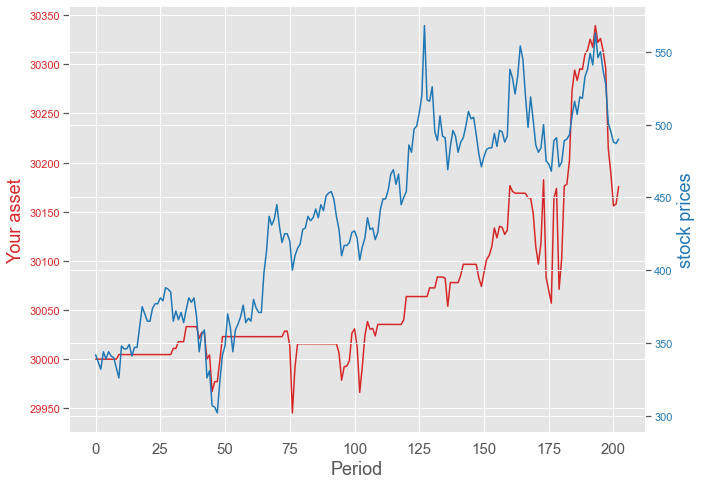

This is  apple  stocks
Your asset became $ 30013.9 ( 2 stocks & $ 29784.0 )
Your asset increased  0.05 % while stock price increased  49.35 %


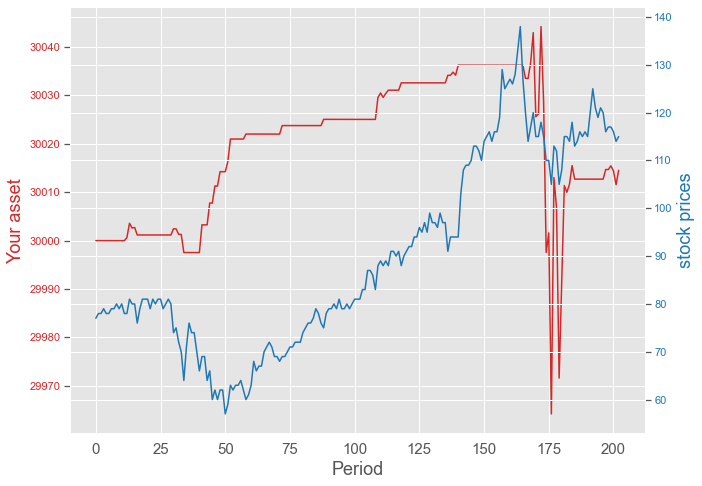

This is  amazon  stocks
Your asset became $ 31404.4 ( 5 stocks & $ 15322.0 )
Your asset increased  4.68 % while stock price increased  68.85 %


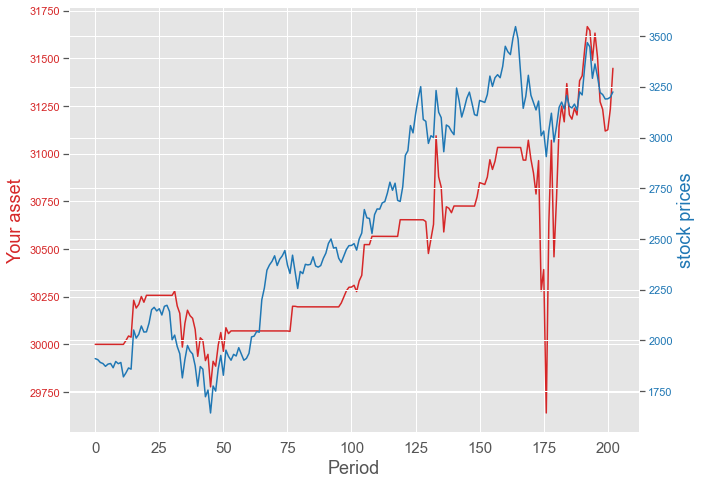

This is  google  stocks
Your asset became $ 31614.4 ( 9 stocks & $ 17291.0 )
Your asset increased  5.38 % while stock price increased  12.32 %


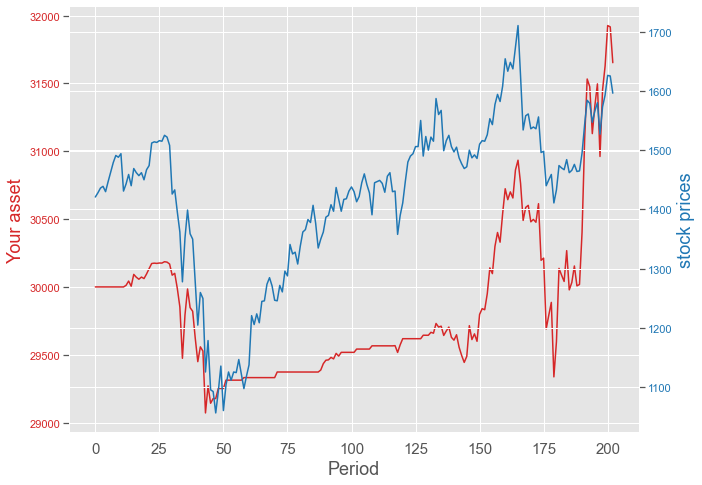

In [61]:
for i in range(len(our_data)):
    
    print("This is ",our_name[i]," stocks")
    
    stock = get_thedata2(our_data[i], start, end)
    stock = get_moving(stock)
    stock = get_normalized(stock)
    
    total_asset, track, holding_stocks, track_money, track_price = when_we_buy_sell_stock(stock)
    
    begin_price = track_price[0]
    end_price = track_price[-1]
    
    print("Your asset became $",round(total_asset,1), "(",holding_stocks[-1],"stocks", "& $",track_money[-1],")")
    if total_asset > 30000:
        if end_price > begin_price:
            print("Your asset increased ",round((total_asset-30000)/300,2),"%",
                  "while stock price increased ",round((end_price-begin_price)/begin_price*100,2),"%")
        else:
            print("Your asset increased ",round((total_asset-30000)/300,2),"%",
                  "while stock price decreased ",round((end_price-begin_price)/begin_price*100,2),"%")
    else:
        if end_price > begin_price:
            print("Your asset decreased ",round((total_asset-30000)/300,2),"%",
                  "while stock price increased ",round((end_price-begin_price)/begin_price*100,2),"%")
        else:
            print("Your asset decreased ",round((total_asset-30000)/300,2),"%",
                  "while stock price decreased ",round((end_price-begin_price)/begin_price*100,2),"%")
    
    
    # Visualization #
    
    fig, ax1 = plt.subplots(figsize = (10,7))
    
    track_asset = track
    color = 'tab:red'
    ax1.set_xlabel('Period')
    ax1.set_ylabel('Your asset', color=color)
    ax1.plot(track_asset, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    track_price = track_price
    color = 'tab:blue'
    ax2.set_ylabel('stock prices', color=color)  # we already handled the x-label with ax1
    ax2.plot(track_price, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print("=============================================================================")
    print("=============================================================================")

## 6. Apply model2 algorithm and check the assest ##

The second algorithm was applied with data from Netflix, Google, Amazon, and Apple. Visualize asset changes and share prices. It also represented the structure of the final asset, the growth rate of the asset over the period, and the increase in share prices.

This is  netflix  stocks
Your asset became $ 30370.2 ( 20 stocks & $ 20596.0 )
Your asset increased  1.23 % while stock price increased  43.27 %


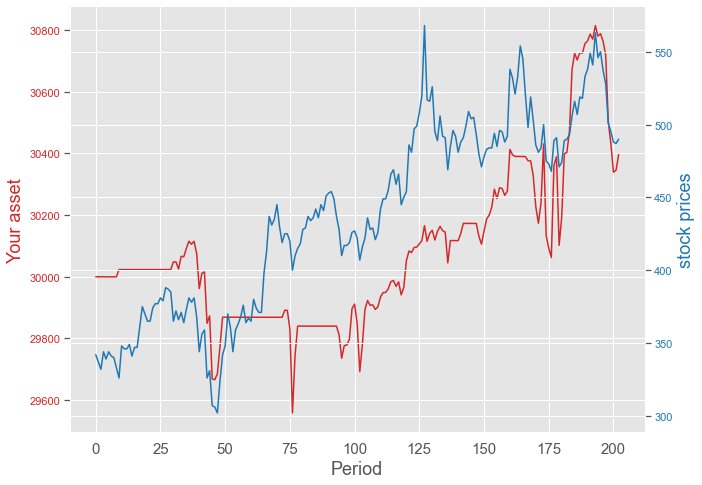

This is  apple  stocks
Your asset became $ 30682.7 ( 35 stocks & $ 26651.0 )
Your asset increased  2.28 % while stock price increased  49.35 %


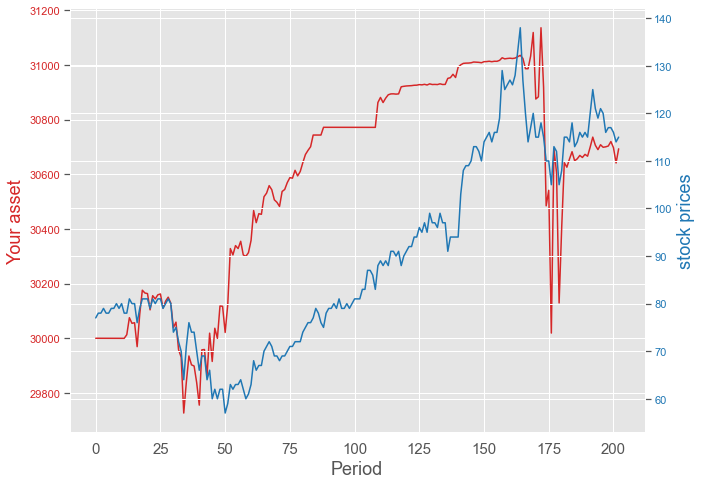

This is  amazon  stocks
Your asset became $ 31404.4 ( 5 stocks & $ 15322.0 )
Your asset increased  4.68 % while stock price increased  68.85 %


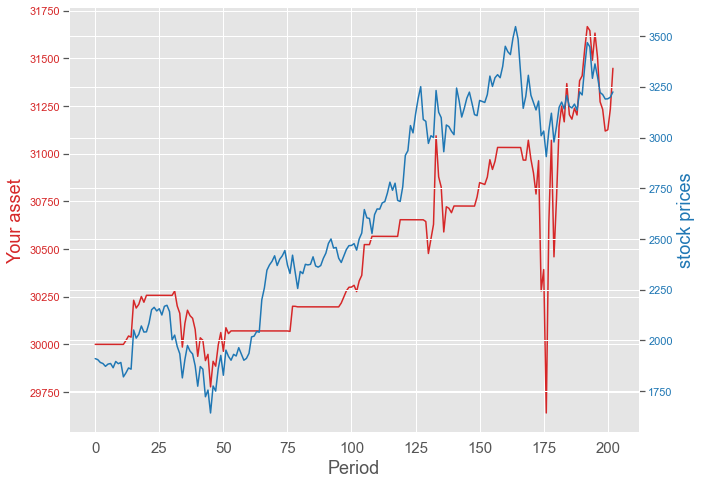

This is  google  stocks
Your asset became $ 31707.7 ( 9 stocks & $ 17385.0 )
Your asset increased  5.69 % while stock price increased  12.32 %


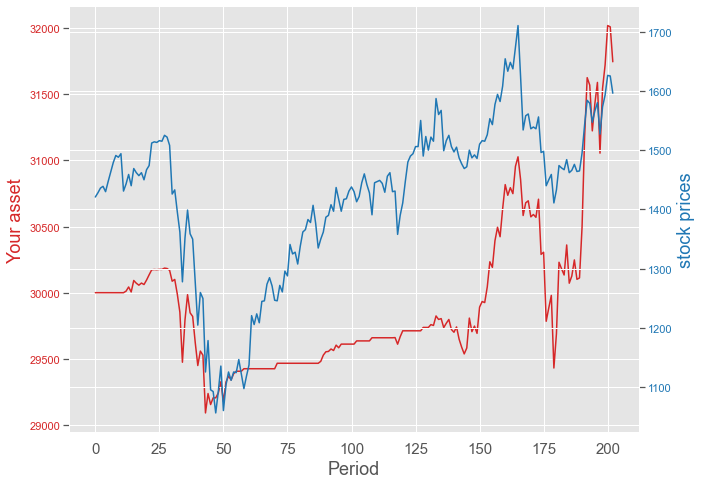

In [62]:

for i in range(len(our_data)):
    
    print("This is ",our_name[i]," stocks")
    stock = get_thedata2(our_data[i], start, end)
    
    
    stock = get_moving(stock)
    stock = get_normalized(stock)
    
    total_asset, track, holding_stocks, track_money, track_price = when_we_buy_sell_stock_amount(stock)
    
    begin_price = track_price[0]
    end_price = track_price[-1]
    
    print("Your asset became $",round(total_asset,1), "(",holding_stocks[-1],"stocks", "& $",track_money[-1],")")
    if total_asset > 30000:
        if end_price > begin_price:
            print("Your asset increased ",round((total_asset-30000)/300,2),"%",
                  "while stock price increased ",round((end_price-begin_price)/begin_price*100,2),"%")
        else:
            print("Your asset increased ",round((total_asset-30000)/300,2),"%",
                  "while stock price decreased ",round((end_price-begin_price)/begin_price*100,2),"%")
    else:
        if end_price > begin_price:
            print("Your asset decreased ",round((total_asset-30000)/300,2),"%",
                  "while stock price increased ",round((end_price-begin_price)/begin_price*100,2),"%")
        else:
            print("Your asset decreased ",round((total_asset-30000)/300,2),"%",
                  "while stock price decreased ",round((end_price-begin_price)/begin_price*100,2),"%")
    
    
    # Visualization #
    
    fig, ax1 = plt.subplots(figsize = (10,7))
    
    track_asset = track
    color = 'tab:red'
    ax1.set_xlabel('Period')
    ax1.set_ylabel('Your asset', color=color)
    ax1.plot(track_asset, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    track_price = track_price
    color = 'tab:blue'
    ax2.set_ylabel('stock prices', color=color)  # we already handled the x-label with ax1
    ax2.plot(track_price, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print("=============================================================================")
    print("=============================================================================")

## 7. Apply model3 algorithm and check the assest ##

The third algorithm was applied with data from Netflix, Google, Amazon, and Apple. Visualize asset changes and share prices. It also represented the structure of the final asset, the growth rate of the asset over the period, and the increase in share prices.

This is  netflix  stocks
Your asset became $ 31291.4 ( 35 stocks & $ 14186.0 )
Your asset increased  4.3 % while stock price increased  43.27 %


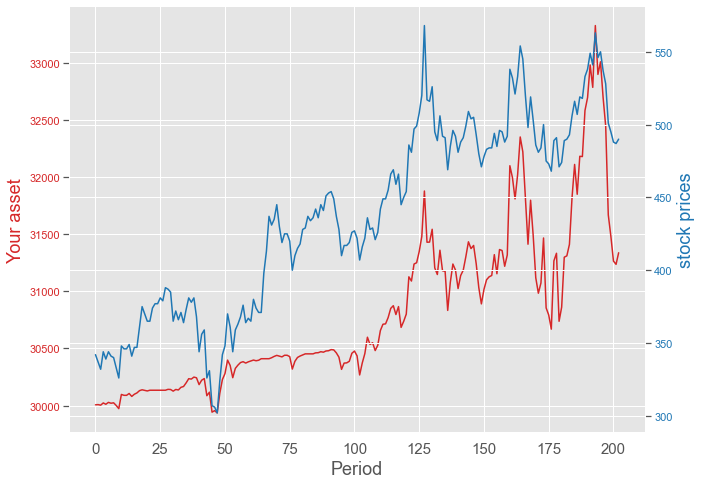

This is  apple  stocks
Your asset became $ 30152.8 ( 12 stocks & $ 28771.0 )
Your asset increased  0.51 % while stock price increased  49.35 %


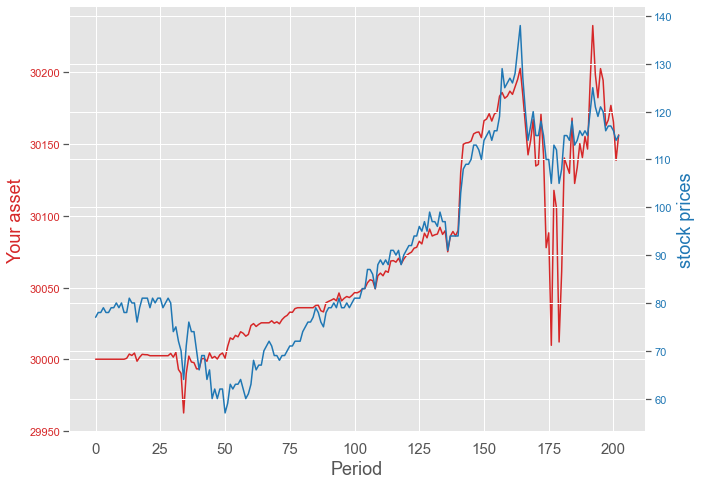

This is  amazon  stocks
Your asset became $ 39059.5 ( 10 stocks & $ 6896.0 )
Your asset increased  30.2 % while stock price increased  68.85 %


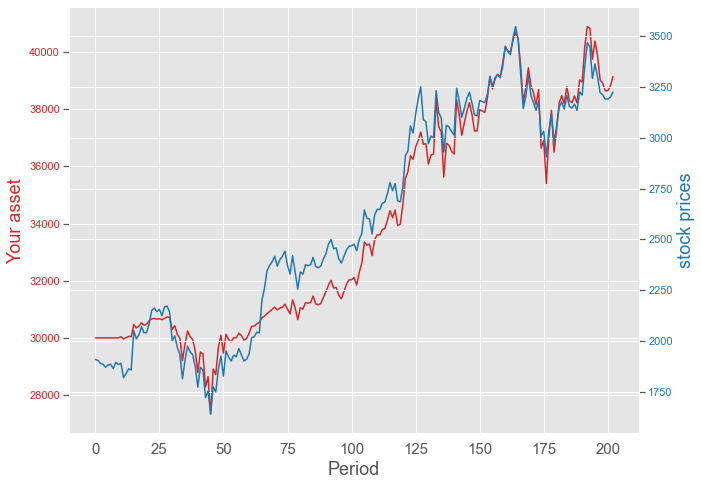

This is  google  stocks
Your asset became $ 34820.5 ( 19 stocks & $ 4583.0 )
Your asset increased  16.07 % while stock price increased  12.32 %


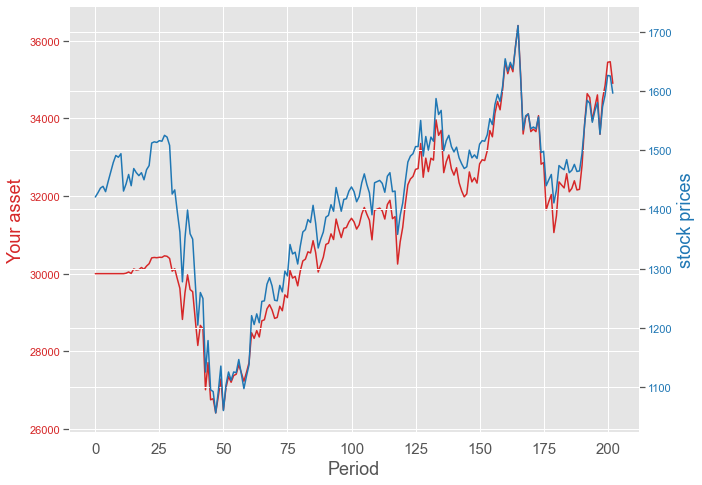

In [63]:

for i in range(len(our_data)):
    
    print("This is ",our_name[i]," stocks")
    stock = get_thedata2(our_data[i], start, end)
    
    
    stock = get_moving(stock)
    stock = get_normalized(stock)
    
    total_asset, track, holding_stocks, track_money, track_price = when_we_buy_sell_buy_stock(stock)
    
    begin_price = track_price[0]
    end_price = track_price[-1]
    
    print("Your asset became $",round(total_asset,1), "(",holding_stocks[-1],"stocks", "& $",track_money[-1],")")
    if total_asset > 30000:
        if end_price > begin_price:
            print("Your asset increased ",round((total_asset-30000)/300,2),"%",
                  "while stock price increased ",round((end_price-begin_price)/begin_price*100,2),"%")
        else:
            print("Your asset increased ",round((total_asset-30000)/300,2),"%",
                  "while stock price decreased ",round((end_price-begin_price)/begin_price*100,2),"%")
    else:
        if end_price > begin_price:
            print("Your asset decreased ",round((total_asset-30000)/300,2),"%",
                  "while stock price increased ",round((end_price-begin_price)/begin_price*100,2),"%")
        else:
            print("Your asset decreased ",round((total_asset-30000)/300,2),"%",
                  "while stock price decreased ",round((end_price-begin_price)/begin_price*100,2),"%")
    
    
    # Visualization #
    
    fig, ax1 = plt.subplots(figsize = (10,7))
    
    track_asset = track
    color = 'tab:red'
    ax1.set_xlabel('Period')
    ax1.set_ylabel('Your asset', color=color)
    ax1.plot(track_asset, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    track_price = track_price
    color = 'tab:blue'
    ax2.set_ylabel('stock prices', color=color)  # we already handled the x-label with ax1
    ax2.plot(track_price, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print("=============================================================================")
    print("=============================================================================")

## 8. Apply model4 algorithm and check the assest ##

The fourth algorithm was applied with data from Netflix, Google, Amazon, and Apple. Visualize asset changes and share prices. It also represented the structure of the final asset, the growth rate of the asset over the period, and the increase in share prices.

This is  netflix  stocks
Your asset became $ 32767.2 ( 25 stocks & $ 20549.0 )
Your asset increased  9.22 % while stock price increased  43.27 %


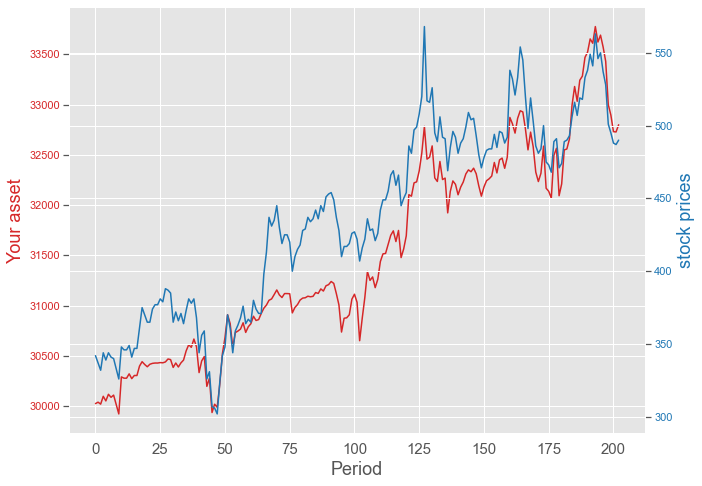

This is  apple  stocks
Your asset became $ 30894.4 ( 37 stocks & $ 26633.0 )
Your asset increased  2.98 % while stock price increased  49.35 %


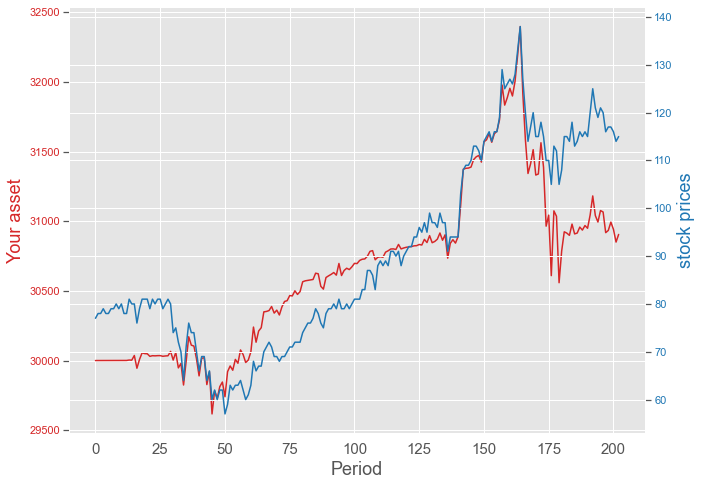

This is  amazon  stocks
Your asset became $ 39059.5 ( 10 stocks & $ 6896.0 )
Your asset increased  30.2 % while stock price increased  68.85 %


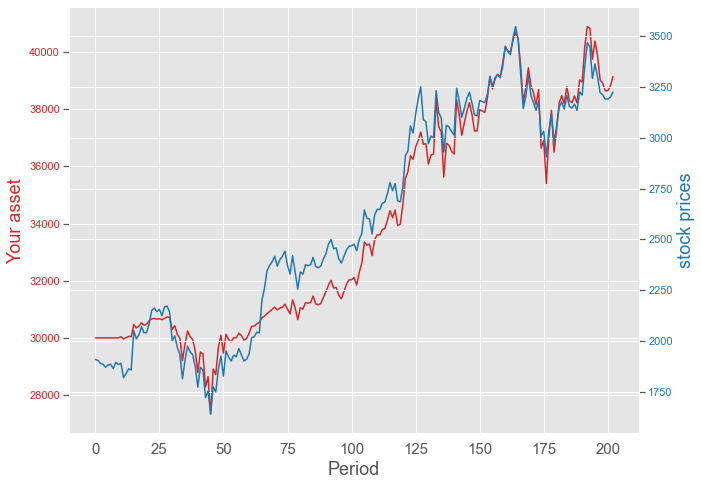

This is  google  stocks
Your asset became $ 32477.9 ( 18 stocks & $ 3832.0 )
Your asset increased  8.26 % while stock price increased  12.32 %


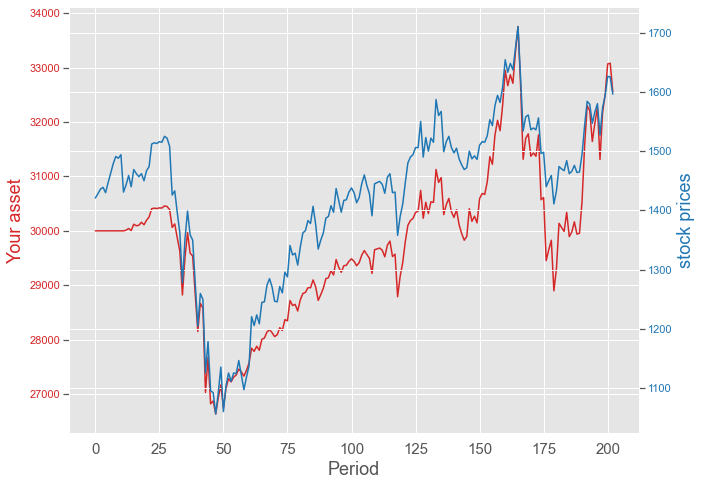

In [64]:
for i in range(len(our_data)):
    
    print("This is ",our_name[i]," stocks")
    stock = get_thedata2(our_data[i], start, end)
    
    
    stock = get_moving(stock)
    stock = get_normalized(stock)
    
    total_asset, track, holding_stocks, track_money, track_price = when_we_buy_sell_buy_stock_amount(stock)
    
    begin_price = track_price[0]
    end_price = track_price[-1]
    
    print("Your asset became $",round(total_asset,1), "(",holding_stocks[-1],"stocks", "& $",track_money[-1],")")
    if total_asset > 30000:
        if end_price > begin_price:
            print("Your asset increased ",round((total_asset-30000)/300,2),"%",
                  "while stock price increased ",round((end_price-begin_price)/begin_price*100,2),"%")
        else:
            print("Your asset increased ",round((total_asset-30000)/300,2),"%",
                  "while stock price decreased ",round((end_price-begin_price)/begin_price*100,2),"%")
    else:
        if end_price > begin_price:
            print("Your asset decreased ",round((total_asset-30000)/300,2),"%",
                  "while stock price increased ",round((end_price-begin_price)/begin_price*100,2),"%")
        else:
            print("Your asset decreased ",round((total_asset-30000)/300,2),"%",
                  "while stock price decreased ",round((end_price-begin_price)/begin_price*100,2),"%")
    
    
    # Visualization #
    
    fig, ax1 = plt.subplots(figsize = (10,7))
    
    track_asset = track
    color = 'tab:red'
    ax1.set_xlabel('Period')
    ax1.set_ylabel('Your asset', color=color)
    ax1.plot(track_asset, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    track_price = track_price
    color = 'tab:blue'
    ax2.set_ylabel('stock prices', color=color)  # we already handled the x-label with ax1
    ax2.plot(track_price, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print("=============================================================================")
    print("=============================================================================")

## 9. compare 4 models and find best model ##

To compare the four algorithms and select the best algorithms, we summarized the results of each company's algorithms with data frames.
The results were tested by a total of three scenarios. (short-term growth market, short-term decline market, long-term market)

In [65]:
def df_maker(col_n, ind_n, fill):
    col=[]
    ind=[]
    con=[]
    for i in range(col_n):
        col.append(fill)
    for i in range(ind_n):
        ind.append(fill)
    for i in range(ind_n):
        con.append(col)
    return pd.DataFrame(con, columns = col, index=ind)

In [66]:
import datetime as dt
import matplotlib.pyplot as plt
import pandas_datareader.data as web
style.use('ggplot')

In [67]:
our_data = ['NFLX', 'AAPL', 'AMZN', 'GOOG']
our_name = ['netflix', 'apple', 'amazon', 'google']

In [68]:
def get_thedata2(name, start, end):
    stock = web.DataReader(name, 'yahoo', start, end)
    stock = stock.reset_index().rename(columns = {"index":"Date"})
    stock = stock[['Date','Open','High','Low']]
    stock.columns=['Date','Open','High','Low']
    stock = stock.reset_index(drop = True)
    return stock

### 9.1. Compare 4 models in short term positive stock markets  ###

In [69]:
compare = df_maker(0, 5, 0)
compare.index = ['Stock price changing',
                 'Buy_Sell_v1',
                'Buy_Sell_v2',
                'Buy_Sell_buy_v1',
                'Buy_Sell_buy_v2',]
for i in range(len(our_data)):
    if i==0:
        start = dt.datetime(2020,4,5)
        end = dt.datetime(2020,5,13)
    elif i==1:
        start = dt.datetime(2020,7,16)
        end = dt.datetime(2020,9,18)
    elif i==2:
        start = dt.datetime(2020,7,2)
        end = dt.datetime(2020,9,1)
    elif i==3:
        start = dt.datetime(2020,6,10)
        end = dt.datetime(2020,8,25)
    
    stock = get_thedata2(our_data[i], start, end)
    
    stock = get_moving(stock)
    stock = get_normalized(stock)
    
    total_asset1, track1, holding_stocks1, track_money1, track_price1 = when_we_buy_sell_stock(stock)
    total_asset2, track2, holding_stocks2, track_money2, track_price2 = when_we_buy_sell_stock_amount(stock)
    total_asset3, track3, holding_stocks3, track_money3, track_price3 = when_we_buy_sell_buy_stock(stock)
    total_asset4, track4, holding_stocks4, track_money4, track_price4 = when_we_buy_sell_buy_stock_amount(stock)
    
    begin_price = track_price1[0]
    end_price = track_price1[-1]
    
    
    history = str(round((end_price-begin_price)/begin_price*100,1))+'%'
    m1 = str(round((total_asset1-30000)/300,1))+'%'
    m2 = str(round((total_asset2-30000)/300,1))+'%'
    m3 = str(round((total_asset3-30000)/300,1))+'%'
    m4 = str(round((total_asset4-30000)/300,1))+'%'
    company = [history, m1, m2, m3, m4]
    compare[our_name[i]] = company
compare

,netflix,apple,amazon,google
Stock price changing,9.5%,13.4%,9.3%,9.3%
Buy_Sell_v1,-0.0%,-0.0%,3.7%,2.9%
Buy_Sell_v2,-0.0%,-0.0%,3.7%,2.9%
Buy_Sell_buy_v1,0.2%,-0.0%,9.6%,4.5%
Buy_Sell_buy_v2,0.3%,0.7%,9.6%,4.5%


### 9.2. Compare 4 models in long term stock markets  ###

In [70]:
start = dt.datetime(2019,6,10)
end = dt.datetime(2020,11,4)


compare = df_maker(0, 5, 0)
compare.index = ['Stock price changing',
                 'Buy_Sell_v1',
                'Buy_Sell_v2',
                'Buy_Sell_buy_v1',
                'Buy_Sell_buy_v2',]
for i in range(len(our_data)):
    """if i==0:
        start = dt.datetime(2020,7,17)
        end = dt.datetime(2020,9,27)
    elif i==1:
        start = dt.datetime(2019,12,17)
        end = dt.datetime(2020,4,17)
    elif i==2:
        start = dt.datetime(2020,7,10)
        end = dt.datetime(2020,9,17)"""
    stock = get_thedata2(our_data[i], start, end)
    
    stock = get_moving(stock)
    stock = get_normalized(stock)
    
    total_asset1, track1, holding_stocks1, track_money1, track_price1 = when_we_buy_sell_stock(stock)
    total_asset2, track2, holding_stocks2, track_money2, track_price2 = when_we_buy_sell_stock_amount(stock)
    total_asset3, track3, holding_stocks3, track_money3, track_price3 = when_we_buy_sell_buy_stock(stock)
    total_asset4, track4, holding_stocks4, track_money4, track_price4 = when_we_buy_sell_buy_stock_amount(stock)
    
    begin_price = track_price1[0]
    end_price = track_price1[-1]
    
    history = str(round((end_price-begin_price)/begin_price*100,1))+'%'
    m1 = str(round((total_asset1-30000)/300,1))+'%'
    m2 = str(round((total_asset2-30000)/300,1))+'%'
    m3 = str(round((total_asset3-30000)/300,1))+'%'
    m4 = str(round((total_asset4-30000)/300,1))+'%'
    company = [history, m1, m2, m3, m4]
    compare[our_name[i]] = company
compare

,netflix,apple,amazon,google
Stock price changing,44.3%,137.5%,68.4%,57.5%
Buy_Sell_v1,0.1%,0.1%,6.0%,11.3%
Buy_Sell_v2,0.8%,4.1%,6.0%,8.4%
Buy_Sell_buy_v1,14.4%,0.9%,29.6%,42.9%
Buy_Sell_buy_v2,8.6%,14.7%,29.6%,36.0%


### 9.3. Compare 4 models in short term negative stock markets  ###

In [71]:
start = dt.datetime(2020,1,9)
end = dt.datetime(2020,3,9)


compare = df_maker(0, 5, 0)
compare.index = ['Stock price changing',
                 'Buy_Sell_v1',
                'Buy_Sell_v2',
                'Buy_Sell_buy_v1',
                'Buy_Sell_buy_v2',]
for i in range(len(our_data)):
    if i==0:
        start = dt.datetime(2020,2,6)
        end = dt.datetime(2020,3,23)
    elif i==1:
        start = dt.datetime(2020,1,26)
        end = dt.datetime(2020,3,10)
    elif i==2:
        start = dt.datetime(2020,8,23)
        end = dt.datetime(2020,9,16)
    elif i==3:
        start = dt.datetime(2020,7,15)
        end = dt.datetime(2020,8,4)
    stock = get_thedata2(our_data[i], start, end)
    
    stock = get_moving(stock)
    stock = get_normalized(stock)
    
    total_asset1, track1, holding_stocks1, track_money1, track_price1 = when_we_buy_sell_stock(stock)
    total_asset2, track2, holding_stocks2, track_money2, track_price2 = when_we_buy_sell_stock_amount(stock)
    total_asset3, track3, holding_stocks3, track_money3, track_price3 = when_we_buy_sell_buy_stock(stock)
    total_asset4, track4, holding_stocks4, track_money4, track_price4 = when_we_buy_sell_buy_stock_amount(stock)
    
    begin_price = track_price1[0]
    end_price = track_price1[-1]
    
    history = str(round((end_price-begin_price)/begin_price*100,1))+'%'
    m1 = str(round((total_asset1-30000)/300,1))+'%'
    m2 = str(round((total_asset2-30000)/300,1))+'%'
    m3 = str(round((total_asset3-30000)/300,1))+'%'
    m4 = str(round((total_asset4-30000)/300,1))+'%'
    company = [history, m1, m2, m3, m4]
    compare[our_name[i]] = company
compare

,netflix,apple,amazon,google
Stock price changing,-7.7%,-9.2%,-6.7%,-5.3%
Buy_Sell_v1,0.0%,-0.1%,-0.8%,-0.6%
Buy_Sell_v2,-0.2%,-1.3%,-0.8%,-0.6%
Buy_Sell_buy_v1,0.3%,-0.2%,-1.3%,-0.8%
Buy_Sell_buy_v2,0.8%,-0.2%,-1.3%,-0.8%


Although the assets did not increase as much when the share price rose in the short term, they also confirmed that the assets could be preserved well when the share price fell in the short term.
And in the long run, it guaranteed a certain rate of return.
Although the four models showed different strengths and weaknesses, the fourth model was selected as the best model considering the average return.

## 10. Apply best model to testset##

To test the best model, data from 15 companies in Nasdaq were collected except Apple, Google, and Amazon.
The 15 companies' 2018, 2019 data will be subject to the same hypothesis tests as in Chapter 3 and equity investments will be made only for companies that have passed.

### 10.1. Prepare dataset from the web directly ###

In [72]:
our_data = ['MMM','AXP','BA','KO','INTC','IBM','NKE','MCD','MSFT','VZ','WMT','HD','UNH','V','XOM']
our_name = ['3M','American Express','Boeing', 'Coca-Cola','Intel',
            'IBM','Nike',"Mcdonald's", 'Microsoft','Verizon','Wal-mart',
            'De Home Depot','UnitedHealth Group','Visa','ExxonMobil']

### 10.2. Hypothesis test and select proper company ###

In [73]:
start = dt.datetime(2018,1,1)
end = dt.datetime(2019,12,31)
pass_company_name = []
passing_company_tag = []
for i in range(len(our_data)):
    
    print("This is ",our_name[i]," stocks")
    
    stock = get_thedata2(our_data[i], start, end)
    stock = get_moving(stock)
    stock = get_normalized(stock)
    
    ttest = stock[['check_high','check_low', 'normalized_open', 'normalized_moving']]
    ttest_high_cheap, ttest_high_normal, ttest_low_cheap, ttest_low_normal = prepare_t_test(ttest)
    
    lresult = stats.levene(ttest_high_cheap, ttest_high_normal)
    #print('LeveneResult(F) : %.3f \np-value : %.3f' % (lresult))
    if lresult[1] < 0.05:
        equal_variance = False
    else:
        equal_variance = True
    #print(lresult[1])
    print("-----------------Highest------------------------")
    result = stats.ttest_ind(ttest_high_cheap, ttest_high_normal, equal_var=equal_variance) 
    print('p-value : %.3f' % (result[1]))
    if result[1] < 0.05:
        high_pass = True
    else:
        high_pass = False
    print("-----------------Lowest-----------------------")
    lresult = stats.levene(ttest_low_cheap, ttest_low_normal)
    if lresult[1] < 0.05:
        equal_variance = False
    else:
        equal_variance = True
    #print('LeveneResult(F) : %.3f \np-value : %.3f' % (lresult))
    result = stats.ttest_ind(ttest_low_cheap, ttest_low_normal, equal_var=equal_variance) 
    print('p-value : %.3f' % (result[1]))
    if result[1] < 0.05:
        low_pass = True
    else:
        low_pass = False
        
    print("-----------------Result-----------------------")
    if high_pass and low_pass:
        pass_company_name.append(our_name[i])
        passing_company_tag.append(our_data[i])
        print("pass")
    else:
        print("not proper to this algorithm")
    print("======================================================")
    print("======================================================")
print(pass_company_name)
print(passing_company_tag)

This is  3M  stocks
-----------------Highest------------------------
p-value : 0.162
-----------------Lowest-----------------------
p-value : 0.000
-----------------Result-----------------------
not proper to this algorithm
This is  American Express  stocks
-----------------Highest------------------------
p-value : 0.003
-----------------Lowest-----------------------
p-value : 0.000
-----------------Result-----------------------
pass
This is  Boeing  stocks
-----------------Highest------------------------
p-value : 0.010
-----------------Lowest-----------------------
p-value : 0.000
-----------------Result-----------------------
pass
This is  Coca-Cola  stocks
-----------------Highest------------------------
p-value : 0.000
-----------------Lowest-----------------------
p-value : 0.018
-----------------Result-----------------------
pass
This is  Intel  stocks
-----------------Highest------------------------
p-value : 0.001
-----------------Lowest-----------------------
p-value : 0.010


Only 13 companies, excluding 3M and Exxonmobile, were selected for investment as a result of the hypothesis test.

### 10.3. Apply best model to the selected company ###

The data for 2020 were applied to 13 selected companies and showed share price and asset growth rates for each company.
The average value of the indicators is also tracked separately.

In [74]:
start = dt.datetime(2020,1,1)
end = dt.datetime(2020,11,5)
total_history = []
total_profit = []

compare = df_maker(0, 2, 0)
compare.index = ['Stock price changing',
                'Buy_Sell_buy_v2',]
for i in range(len(passing_company_tag)):
    
    stock = get_thedata2(passing_company_tag[i], start, end)
    
    stock = get_moving(stock)
    stock = get_normalized(stock)
    
    total_asset4, track4, holding_stocks4, track_money4, track_price4 = when_we_buy_sell_buy_stock_amount(stock)
    
    begin_price = track_price4[0]
    end_price = track_price4[-1]
    
    history = str(round((end_price-begin_price)/begin_price*100,1))+'%'
    m4 = str(round((total_asset4-30000)/300,1))+'%'
    
    total_history.append(round((end_price-begin_price)/begin_price*100,1))
    total_profit.append(round((total_asset4-30000)/300,1))
    company = [history, m4]
    compare[pass_company_name[i]] = company
compare['Total'] = [str(round(np.mean(total_history),2))+'%', str(round(np.mean(total_profit),2))+'%']

compare

,American Express,Boeing,Coca-Cola,Intel,IBM,Nike,Mcdonald's,Microsoft,Verizon,Wal-mart,De Home Depot,UnitedHealth Group,Visa,Total
Stock price changing,-23.0%,-54.6%,-9.1%,-22.0%,-16.9%,26.5%,4.3%,37.0%,-1.7%,24.1%,29.1%,21.8%,2.6%,1.39%
Buy_Sell_buy_v2,-0.7%,-15.8%,3.3%,1.8%,-8.2%,3.5%,6.5%,5.3%,1.0%,6.9%,12.0%,10.5%,6.9%,2.54%


For companies whose stock prices have risen significantly during 2020, their assets have not increased as much as their share price increases, but they have shown not a bad growth rate. What is remarkable is that it was able to defend a significant amount of assets against companies whose stock prices have fallen significantly.
In addition, the combined 13 company indexes showed a 1.39 percent increase in share prices, but a 2.54 percent increase in average assets. Such asset growth is a good result for most investors to make distributed investments.

Of course I'm not an expert in investment and economics. Nor do I know anything about the value and information of a company. I was just curious about the results of repeated investments in consideration of statistical trends, and I'm very happy to see good results.